### Part1: Load Dataset (Query Result From SQL), Data Cleaning and Feature Engineering 

About __Episode__, is a mobile storytelling network and platform that features interactive Hollywood-caliber stories built from the ground up for mobile. It ranked #1 in role-playing games on App Store and was released on Feb 2014. The goal of this project is to devise a scheme to specify a target group and offer a promotion, therefore maximize incremental revenue. You need to prescribe a test protocol that can be used to evaluate the results. 

The main purpose of the notebook is to clean the data from SQL selection and generate [new features](https://gameanalytics.com/blog/metrics-all-game-developers-should-know.html). 

- Original Features:   
__users__: udid, install_date, lang, country, hw_ver, os_ver  
__sessions__: session_ts, session_date, session_num (ordered by session_ts)  
__iaps__: iaps_ts, iaps_date, prod_name, prod_type, rev (ordered by iaps_ts)  
__spendevents__: spend_ts, spend_date, story+chapter, spendtype (contains the information of iaps), currency (all the same), amount (ordered by spend_ts) 

- Generated Features:  
__delta_days_sess__, __delta_days_spend__, __delta_days_iaps__ are the time difference between each session/spend/purchase and installment date in units of days.  
__total_story__ is the total num of unique stories&chapters episode users played.  
__total_session/spend__ are the total num of sessions/purchase per user.  
__active_session/spend_day__ are the number of days each user that start/spend money at least one session in the app on any given day.  
__avg_session_duration__ averaged session duration.  
__avg_session_per_day__ the averaged number of sessions per day.    
__avg_amount_per_day__ averaged spent amount per day.   
__max_session_per_day__ max num of sessions per day.   
__retention_1/3/7/30__ if user is active on 1/3/7/30 days after they download the app (only used in the second case).  
__rev/amount_sum__ are the sum of rev/spend amount of each user.  
__amount_max__ max abs(amount spent) of each user.  
__weekend__ the weekend information of the installment (0 is weekday and 1 is weekend).  
__payer__ self-converted customers.  

__Note__: 
1. The problem is to identify the possible self-converted customers. To build the model, I tried to use data in two different ways 1) take only the first 24 hrs data of each user after the user starts playing the game 2) take the continuous daily data each user plays the game until the 24 hr break point. Based on the performance of the model results, I go with the __second method__. 

2. *Spendevents* can not be really used, because it contains the iaps purchase information (i.e., see spendtype).   

In [1]:
import pandas as pd
import numpy as np
from pylab import *
%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [4]:
#self-defined
import hw
from hw import *

In [6]:
df = pd.read_csv('query_result.csv') # all the columns become object datatype, results from SQL selection  
print('Len of the data',len(df))
df.tail(2)

Len of the data 22576


,udid,install_date,lang,country,hw_ver,os_ver,session_num,session_ts,session_date,iaps_ts,iaps_date,prod_name,prod_type,rev,spend_ts,spend_date,story,spendtype,currency,amount
22574,a4eb133e656a44569895bb75e08c7048,2016-03-07,es,MX,"iPod7,1",9.2,"1,2,3,4","2016-03-07 22:20:51,2016-03-08 19:50:55,2016-0...","2016-03-07,2016-03-08,2016-03-08,2016-03-08",NaN,NaN,NaN,NaN,NaN,2016-03-07 22:23:18,2016-03-07,story_10,earnGemsCounter,gems,-22
22575,50c27649127e456b85d63e8cff304c4b,2016-03-07,en,US,"iPod5,1",9.2.1,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19","2016-03-07 22:27:26,2016-03-08 05:53:45,2016-0...","2016-03-07,2016-03-08,2016-03-08,2016-03-08,20...",NaN,NaN,NaN,NaN,NaN,"2016-03-07 22:37:56,2016-03-07 22:37:56","2016-03-08,2016-03-08","story_10,story_10","earnGemsCounter,earnGemsCounter","gems,gems","-22,-22"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22576 entries, 0 to 22575
Data columns (total 20 columns):
udid            22576 non-null object
install_date    22576 non-null object
lang            22576 non-null object
country         22564 non-null object
hw_ver          22576 non-null object
os_ver          22576 non-null object
session_num     22544 non-null object
session_ts      22544 non-null object
session_date    22544 non-null object
iaps_ts         1526 non-null object
iaps_date       1526 non-null object
prod_name       1526 non-null object
prod_type       1526 non-null object
rev             1526 non-null object
spend_ts        18017 non-null object
spend_date      18017 non-null object
story           18017 non-null object
spendtype       18017 non-null object
currency        18017 non-null object
amount          18017 non-null object
dtypes: object(20)
memory usage: 3.4+ MB


In [8]:
df['install_date']=df['install_date'].astype('datetime64[ns]')
df['os_ver'] = df['os_ver'][pd.notnull(df['os_ver'])].str.replace('.','').apply(int)

In [9]:
for col in ['session_ts', 'spend_ts', 'iaps_ts', 'rev', \
            'amount','spendtype','session_num','session_date','spend_date','story']:
    df[col] = df[col][pd.notnull(df[col])].str.split(",")

In [10]:
def output_before_break(col, index):
    try:
        output = col[0:(index+1)]
    except (TypeError, ValueError):
        output = col
        pass
    return output

In [11]:
df['index_session'] = df.apply(lambda x: session_before_break(x['session_ts']),axis=1)

In [12]:
df['session_num'] = df.apply(lambda x: output_before_break(x['session_num'],x['index_session']),axis=1)
df['session_ts'] = df.apply(lambda x: output_before_break(x['session_ts'],x['index_session']),axis=1)
df['session_date'] = df.apply(lambda x: output_before_break(x['session_date'],x['index_session']),axis=1)

In [13]:
df['index_spend'] = df.apply(lambda x: spend_before_break(x['spend_ts'],x['session_ts']),axis=1)
df['amount'] = df.apply(lambda x: output_before_break(x['amount'],x['index_spend']),axis=1)
df['spend_ts'] = df.apply(lambda x: output_before_break(x['spend_ts'],x['index_spend']),axis=1)
df['spend_date'] = df.apply(lambda x: output_before_break(x['spend_date'],x['index_spend']),axis=1)
df['story'] = df.apply(lambda x: output_before_break(x['story'],x['index_spend']),axis=1)

In [14]:
def df_feature_engineer(df):
    #df['delta_days_iaps'] = df.apply(lambda x: get_time_delta(x['iaps_ts'],x['install_date']),axis=1)
    df['delta_days_sess'] = df.apply(lambda x: get_time_delta(x['session_ts'],x['install_date']),axis=1)
    df['delta_days_spend'] = df.apply(lambda x: get_time_delta(x['spend_ts'],x['install_date']),axis=1)
    #story 
    df['total_story'] = df['story'][pd.notnull(df['story'])].apply(unique).apply(len)
    #rev, amount 
    df['rev'] = df['rev'][pd.notnull(df['rev'])].apply(lambda x:list(map(int, x)))
    df['amount'] = df['amount'][pd.notnull(df['amount'])].apply(lambda x:list(map(int, x)))

    df['rev_sum'] = df['rev'][pd.notnull(df['rev'])].apply(sum)
    df['amount_sum'] = df['amount'][pd.notnull(df['amount'])].apply(sum)

    df['total_session'] = df['session_num'][pd.notnull(df['session_num'])].apply(lambda x: len(x))
    df['total_spend'] = df['spend_date'][pd.notnull(df['spend_date'])].apply(len)

    df['amount_max'] = df['amount'][pd.notnull(df['amount'])].apply(lambda x: max(map(abs, x)) if x else None)

    df['session_date_dic'] = df['session_date'][pd.notnull(df['session_date'])].apply(lambda x:dict(Counter(x)))
    df['spend_date_dic'] = df['spend_date'][pd.notnull(df['spend_date'])].apply(lambda x:dict(Counter(x)))

    df['active_session_days'] = df['session_date'][pd.notnull(df['session_date'])].apply(unique).apply(len)
    df['active_spend_days'] = df['spend_date'][pd.notnull(df['spend_date'])].apply(unique).apply(len)

    df['avg_session_per_day'] = df['session_date'][pd.notnull(df['session_date'])].\
                apply(lambda x: mean(list(Counter(x).values())))
    df['avg_amount_per_day'] = df['amount_sum']/df['active_session_days']
                                                                                

    df['avg_session_duration'] = df['delta_days_sess'][pd.notnull(df['delta_days_sess'])].\
                        apply(lambda x: mean(np.diff(x))) 
    
    df['avg_spend_duration'] = df['delta_days_spend'][pd.notnull(df['delta_days_spend'])].\
                        apply(lambda x: mean(np.diff(x)))

    df['retention_1'] = df['delta_days_sess'][pd.notnull(df['delta_days_sess'])].apply(lambda x: retention(x,1))
    df['retention_3'] = df['delta_days_sess'][pd.notnull(df['delta_days_sess'])].apply(lambda x: retention(x,3))
    df['retention_7'] = df['delta_days_sess'][pd.notnull(df['delta_days_sess'])].apply(lambda x: retention(x,7))
    df['retention_30'] = df['delta_days_sess'][pd.notnull(df['delta_days_sess'])].apply(lambda x: retention(x,30))

    df['weekend'] = np.where(df['install_date'].apply(lambda x: x.weekday())>4,1,0) # 
    df['payer'] = np.where(df['rev'].notnull(),1,0)

    df['payer'][18818] = 1 # df['IAP'] = df['spendtype'][pd.notnull(df['spendtype'])].apply(lambda x: spend_iap(x))
    #df[(df['payer'] ==0) & (df['IAP'] ==1)]
    return df

In [15]:
df = df_feature_engineer(df)

In [16]:
df.columns

Index(['udid', 'install_date', 'lang', 'country', 'hw_ver', 'os_ver',
       'session_num', 'session_ts', 'session_date', 'iaps_ts', 'iaps_date',
       'prod_name', 'prod_type', 'rev', 'spend_ts', 'spend_date', 'story',
       'spendtype', 'currency', 'amount', 'index_session', 'index_spend',
       'delta_days_sess', 'delta_days_spend', 'total_story', 'rev_sum',
       'amount_sum', 'total_session', 'total_spend', 'amount_max',
       'session_date_dic', 'spend_date_dic', 'active_session_days',
       'active_spend_days', 'avg_session_per_day', 'avg_amount_per_day',
       'avg_session_duration', 'avg_spend_duration', 'retention_1',
       'retention_3', 'retention_7', 'retention_30', 'weekend', 'payer'],
      dtype='object')

In [17]:
df_new = df.drop(columns=['story','currency','session_num',\
                      'spendtype','session_ts','iaps_ts','spend_ts',\
                      'session_date','spend_date','index_session','index_spend'])

In [18]:
df_new.columns

Index(['udid', 'install_date', 'lang', 'country', 'hw_ver', 'os_ver',
       'iaps_date', 'prod_name', 'prod_type', 'rev', 'amount',
       'delta_days_sess', 'delta_days_spend', 'total_story', 'rev_sum',
       'amount_sum', 'total_session', 'total_spend', 'amount_max',
       'session_date_dic', 'spend_date_dic', 'active_session_days',
       'active_spend_days', 'avg_session_per_day', 'avg_amount_per_day',
       'avg_session_duration', 'avg_spend_duration', 'retention_1',
       'retention_3', 'retention_7', 'retention_30', 'weekend', 'payer'],
      dtype='object')

In [19]:
df_new.to_csv('df_break.csv',index=False)

In [20]:
df_new.tail(2)

,udid,install_date,lang,country,hw_ver,os_ver,iaps_date,prod_name,prod_type,rev,...,avg_session_per_day,avg_amount_per_day,avg_session_duration,avg_spend_duration,retention_1,retention_3,retention_7,retention_30,weekend,payer
22574,a4eb133e656a44569895bb75e08c7048,2016-03-07,es,MX,"iPod7,1",92,NaN,NaN,NaN,NaN,...,2.0,-11.0,0.299225,NaN,1.0,0.0,0.0,0.0,0,0
22575,50c27649127e456b85d63e8cff304c4b,2016-03-07,en,US,"iPod5,1",921,NaN,NaN,NaN,NaN,...,4.5,-22.0,0.079097,0.0,1.0,0.0,0.0,0.0,0,0


Okay, now I have re-organized the dataset and done the feature engineer. Now feature exploration, visulazation and modeling. 

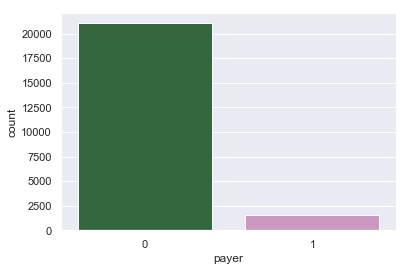

In [21]:
# binary classification 
countplt = sns.countplot(x = 'payer', data = df_new, palette='cubehelix')

In [22]:
df_new.groupby('payer').count()['udid']

payer
0    21049
1     1527
Name: udid, dtype: int64

In [23]:
rev_customer = df[df['rev'].notnull()]

In [39]:
def compare_time(sess_ts, rev_ts):
    if pd.to_datetime(sess_ts[-1]) > pd.to_datetime(rev_ts[0]):
        return 1
    else:
        return 0

In [41]:
rev_customer['fpb'] = rev_customer.apply(lambda x: compare_time(x['session_ts'],x['iaps_ts']), axis =1)

In [51]:
print('Percentage of Customers Finish the First Purchase before the 24hr break',\
      sum(rev_customer['fpb'])/len(rev_customer['fpb']))

Percentage of Customers Finish the First Purchase before the 24hr break 0.6998689384010485


__Summary_Part1_Data__ 


1. The data contains the activity information of 22576 users. The label is imbalanced (1527 vs 21049). 6.76% of the total customers in the whole dataset are true payers. Note: there is one missing labeled self-converted customer based on the spendtype information in the spendtype I have corrected.

2. Generated features based on the session/spend activities, all before the break point of the continuous use of the app of each customer. There is quite some noise in the dataset, for example, in the amount column, there appear extreme numbers such as -300000. Do not know why.  

3. Before the first 24hrs break, 70% self-converted customers already finished their first purchase. 